<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/Support_Vector_RegressionB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective
The goal of this study is to apply Support Vector Regression to predict monthly crude oil price. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


 ### Loading the libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

###Write Functions to Facilitate Evaluation Metrics

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load Data

In [4]:
df = pd.read_csv("/content/gdrive/MyDrive/raw_data/df3.csv")
date_rng = pd.date_range(start='2002-02-28', end='2021-03-31', freq='M')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  230 non-null    int64  
 1   Month       230 non-null    object 
 2   cpo_pri     230 non-null    int64  
 3   cno_pri     230 non-null    int64  
 4   sbo_pri     230 non-null    float64
 5   pno_pri     230 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 10.9+ KB


###Data pre-processing

In [6]:
df['Month'] = df['Month'].apply(pd.to_datetime)
df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])

In [7]:
del df['Unnamed: 0']

In [8]:
del df['Month']

In [9]:
df.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
0,323,455,468.0,844.0,2002-02-28
1,345,546,485.0,799.0,2002-03-31
2,362,595,466.0,718.0,2002-04-30
3,376,636,442.0,614.0,2002-05-31
4,383,738,429.0,619.0,2002-06-30


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   cpo_pri    230 non-null    int64         
 1   cno_pri    230 non-null    int64         
 2   sbo_pri    230 non-null    float64       
 3   pno_pri    230 non-null    float64       
 4   TimeIndex  230 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.1 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2738409d0>,
      dtype=object)

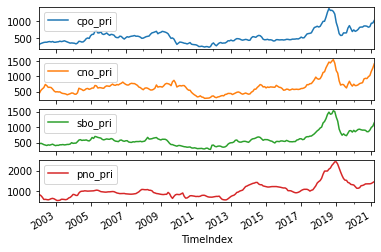

In [11]:
df.set_index('TimeIndex')[['cpo_pri', 'cno_pri','sbo_pri', 'pno_pri']].plot(subplots=True)

In [12]:
df.set_index('TimeIndex')

,cpo_pri,cno_pri,sbo_pri,pno_pri
TimeIndex,,,,
2002-02-28,323,455,468.00,844.00
2002-03-31,345,546,485.00,799.00
2002-04-30,362,595,466.00,718.00
2002-05-31,376,636,442.00,614.00
2002-06-30,383,738,429.00,619.00
...,...,...,...,...
2020-11-30,826,993,860.28,1366.87
2020-12-31,844,1031,910.82,1366.87
2021-01-31,944,1170,997.62,1383.90


###Visualize the Monthly Crude Palm Oil Time-Series

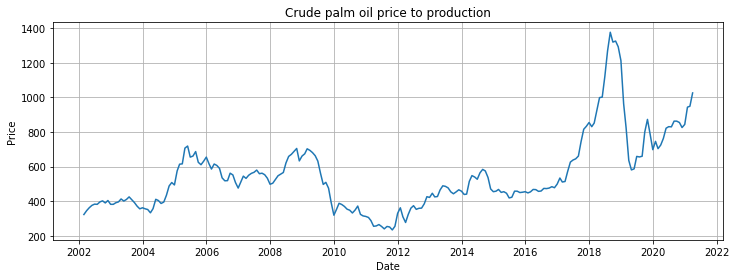

In [13]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df.TimeIndex, df.cpo_pri)
plt.title('Crude palm oil price to production')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

In [16]:
# We split our dataset to be able to evaluate our models
split_date = '2017-06'
df_training = df.loc[df.TimeIndex <= split_date]
df_test = df.loc[df.TimeIndex > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

184 days of training data 
 46 days of testing data 


In [19]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.TimeIndex
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [20]:
x = df[['cno_pri', 'sbo_pri', 'pno_pri']]
y = df[['cpo_pri']]

In [21]:
scaler_x = MinMaxScaler()   
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))       
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))               
yscale=scaler_y.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [22]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)

###Split into Train and Test Sets:

In [ ]:
split_date = '2017-06'
df_training = df.loc[df.TimeIndex <= split_date]
df_test = df.loc[df.TimeIndex > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

184 days of training data 
 46 days of testing data 


In [ ]:
# Create time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
x = df[['cno_pri', 'sbo_pri', 'pno_pri']]
y = df[['cpo_pri']]

In [ ]:
#y = np.reshape(y, (-1,1))

###Scale the Data

In [ ]:
scaler_x = MinMaxScaler()   
scaler_y = MinMaxScaler()
print(scaler_x.fit(x))       
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))               
yscale=scaler_y.transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

###SVR Regressor

In [23]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
svr_pred = reg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


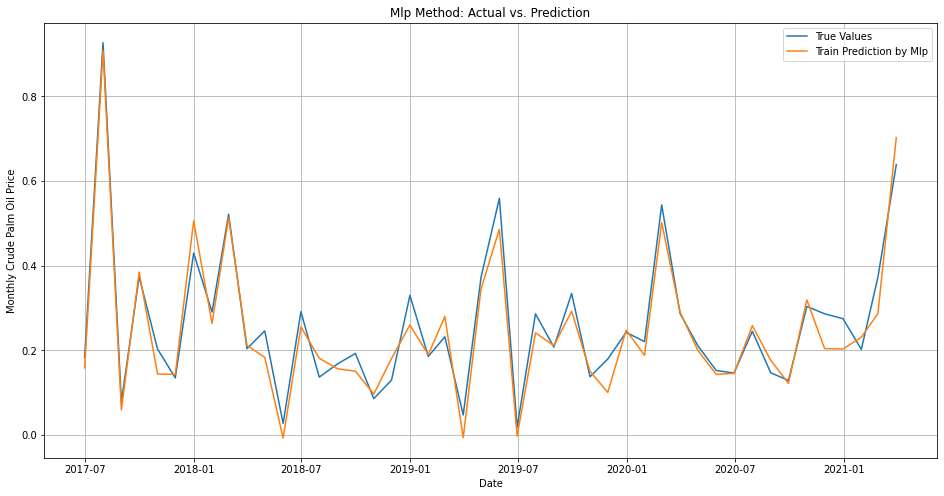

In [97]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.TimeIndex, y_test,  label = 'Test')
plt.plot(df_test.TimeIndex, svr_pred ,label = 'MLP Prediction')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

In [46]:
svr_predR = scaler_y.inverse_transform(svr_pred)

In [47]:
svr_predR 

array([[ 414.89563506],
       [1271.54924205],
       [ 301.4760098 ],
       [ 673.79205248],
       [ 398.41685482],
       [ 397.59734128],
       [ 812.2074713 ],
       [ 534.48193247],
       [ 820.51239446],
       [ 475.84995759],
       [ 443.26176716],
       [ 225.66558515],
       [ 525.87526743],
       [ 440.95396856],
       [ 412.65018722],
       [ 406.13175472],
       [ 344.27478876],
       [ 440.46799064],
       [ 530.66421457],
       [ 450.88166964],
       [ 553.74875676],
       [ 226.65427758],
       [ 628.03751852],
       [ 789.42051047],
       [ 230.98409646],
       [ 509.62814717],
       [ 475.08641491],
       [ 567.70945242],
       [ 405.7760627 ],
       [ 348.88242818],
       [ 517.00498759],
       [ 448.75867186],
       [ 807.06993114],
       [ 566.06681969],
       [ 462.40878601],
       [ 397.52649787],
       [ 400.21648451],
       [ 528.99063823],
       [ 435.70643471],
       [ 373.15138326],
       [ 598.55361527],
       [ 467.028

In [48]:
testY = scaler_y.inverse_transform(y_test)

In [49]:
testY2 = pd.DataFrame(testY, columns = ['Predictions'])

In [50]:
testY2

,Predictions
0,443.0
1,1293.0
2,323.0
3,661.0
4,466.0
5,388.0
6,725.0
7,566.0
8,830.0
9,467.0


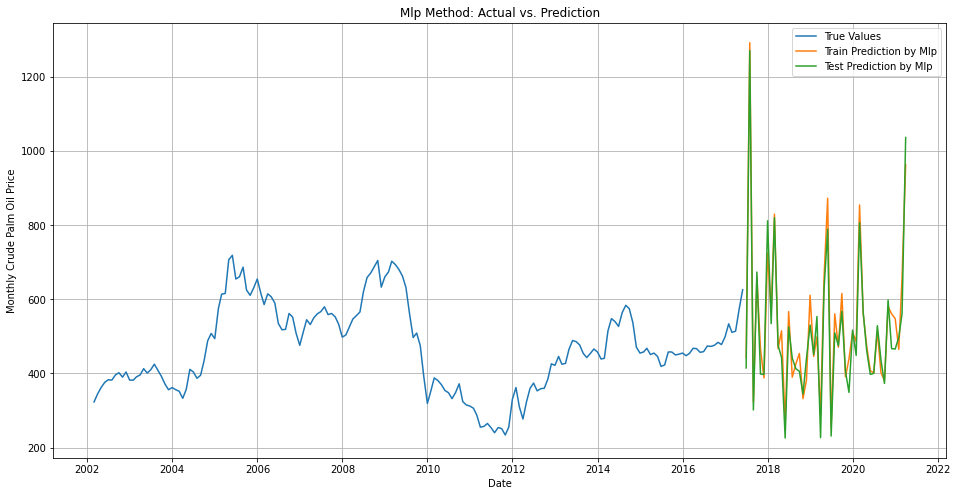

In [51]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.TimeIndex, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.TimeIndex, testY2,  label = 'Test')
plt.plot(df_test.TimeIndex, svr_predR,label = 'MLP Prediction')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by Mlp'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

####SVR Hyper Parameter Tuning Via Grid Search

In [56]:
#tune parameters
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma' :[1, 0.1, 0.01, 0.001,],
             'kernel' :['rbf', 'poly', 'linear'],
              'epsilon': [1e-4, 1e-3]}
model = SVR()
grid = GridSearchCV(SVR(),param_grid,cv = 10, refit = True, verbose =3)
grid.fit(X_train,np.ravel(y_train))
svr_gpred = grid.predict(X_test)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=0.860, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=0.843, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=0.858, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=0.934, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=0.885, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=0.911, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf .

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=-0.228, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly ...................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=0.027, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly ...................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=0.027, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly ...................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=-0.281, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly ...................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=-0.182, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear .................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear, score=0.866, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear .................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear, score=0.823, total=   0.0s
[CV] C=

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:   11.2s finished


In [57]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

#best score
print(grid.best_score_)

{'C': 100, 'epsilon': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.9451066866001794


In [68]:
svr_grid_pred = np.reshape(svr_gpred, (-1,1))

In [69]:
svr_grid_pred  = scaler_y.inverse_transform(svr_grid_pred)

In [70]:
svr_grid_pred

array([[ 409.86145117],
       [1396.69535235],
       [ 304.56657892],
       [ 721.23412845],
       [ 426.97050518],
       [ 388.7290892 ],
       [ 774.81198785],
       [ 543.00417844],
       [ 811.48419941],
       [ 484.71287073],
       [ 484.76590792],
       [ 262.34888226],
       [ 550.10943184],
       [ 434.00947594],
       [ 407.4368628 ],
       [ 404.38815612],
       [ 334.22033422],
       [ 416.23628686],
       [ 546.05476794],
       [ 462.51291154],
       [ 561.49206328],
       [ 264.28191061],
       [ 648.19112543],
       [ 798.80912212],
       [ 267.07941003],
       [ 527.0363702 ],
       [ 489.60030551],
       [ 583.24523242],
       [ 400.29562104],
       [ 407.78802335],
       [ 529.85776729],
       [ 444.82392055],
       [ 826.0302329 ],
       [ 603.86695214],
       [ 433.7300155 ],
       [ 394.32343728],
       [ 396.96436876],
       [ 544.16382036],
       [ 421.86733687],
       [ 363.67935116],
       [ 615.21838812],
       [ 473.050

In [71]:
SVR_predictions = pd.DataFrame(svr_grid_pred, columns = ['svr_Predictions'])

In [72]:
SVR_predictions

,svr_Predictions
0,409.861451
1,1396.695352
2,304.566579
3,721.234128
4,426.970505
5,388.729089
6,774.811988
7,543.004178
8,811.484199
9,484.712871


####Plot the SVR Prediction

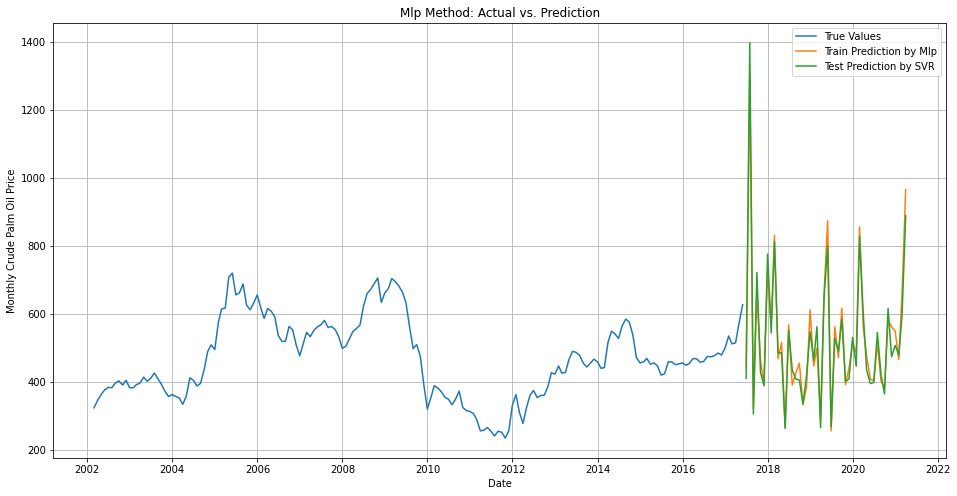

In [84]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_training.TimeIndex, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.TimeIndex, testY2,  label = 'Test')
plt.plot(df_test.TimeIndex, SVR_predictions,label = 'SVR Prediction')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by SVR'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

####Actual vs Predicted Zoomed-In

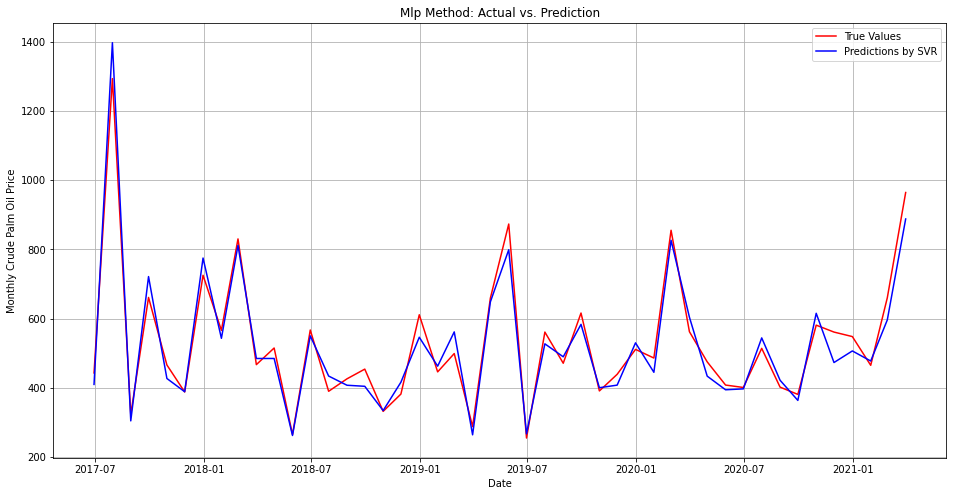

In [85]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.TimeIndex, testY2, color = 'red',  label = 'Test')
plt.plot(df_test.TimeIndex,  SVR_predictions, color = 'blue',label = 'SVR Prediction')
plt.legend(['True Values', 'Predictions by SVR', 'SVR Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

####Compute the Metrics for the MLP Model

In [92]:
MAE_svr = mean_absolute_error(y_test, svr_gpred)
print('MAE value of the SVR Model is:', MAE_svr)

MDA_svr = mda(y_test, svr_gpred)
print('MDA value of the SVR Model is:', MDA_svr)

MAPE_svr = MAPE(y_test, svr_gpred)
print('MAPE value of the SVR Model is:', (MAPE_svr))

RMSE_svr = mean_squared_error(y_test, svr_gpred, squared=False)
print('RMSE value of the SVR Model is:', (RMSE_svr))


MSE_svr = mean_squared_error(y_test, svr_gpred)
print('MSE value of the SVR Model is:', (MSE_svr))

MAE value of the SVR Model is: 0.02904121897289918
MDA value of the SVR Model is: 0.5002469135802469
MAPE value of the SVR Model is: 120.3319953446498
RMSE value of the SVR Model is: 0.03541114790935051
MSE value of the SVR Model is: 0.001253949396257899


In [ ]:
MAE value of the SVR Model is: 0.033374702451863116
MDA value of the SVR Model is: 0.8666666666666667
MAPE value of the SVR Model is: 20.442835824738605
RMSE value of the SVR Model is: 0.041745395608517526
MSE value of the SVR Model is: 0.001742678054511634